<a href="https://colab.research.google.com/github/freshpex/AI-Final-Project/blob/main/AI_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# file = '/content/drive/MyDrive/stock.csv'

file = 'datasets/combined_dataset.csv'

df = pd.read_csv(file)
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10409 entries, 0 to 10408
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10409 non-null  object 
 1   Open       10409 non-null  float64
 2   High       10409 non-null  float64
 3   Low        10409 non-null  float64
 4   Close      10409 non-null  float64
 5   Adj Close  10409 non-null  float64
 6   Volume     10409 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 569.4+ KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10409.000000,10409.000000,10409.000000,10409.000000,10409.000000,1.040900e+04
mean,13.959910,14.111936,13.809163,13.966757,13.350337,3.321778e+08
std,30.169244,30.514878,29.835055,30.191696,29.911132,3.393344e+08
min,0.049665,0.049665,0.049107,0.049107,0.038384,0.000000e+00
25%,0.281964,0.287946,0.274554,0.281250,0.234799,1.247604e+08
50%,0.468750,0.477679,0.459821,0.468750,0.386853,2.199680e+08
75%,14.217857,14.364286,14.043571,14.206071,12.188149,4.126108e+08
max,182.630005,182.940002,179.119995,182.009995,181.778397,7.421641e+09


In [7]:
# Remove time and timezone from 'Date' column
df['Date'] = df['Date'].str.split(' ').str[0]

# Convert the 'Date' column to datetime format, handling errors
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', infer_datetime_format=True)

# drop rows with NaT values in the 'Date' column
df.dropna(subset=['Date'], inplace=True)

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

df.head()


C:\Users\epeki\AppData\Local\Temp\ipykernel_5540\1869855661.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', infer_datetime_format=True)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10409 entries, 1980-12-12 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10409 non-null  float64
 1   High       10409 non-null  float64
 2   Low        10409 non-null  float64
 3   Close      10409 non-null  float64
 4   Adj Close  10409 non-null  float64
 5   Volume     10409 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 569.2 KB


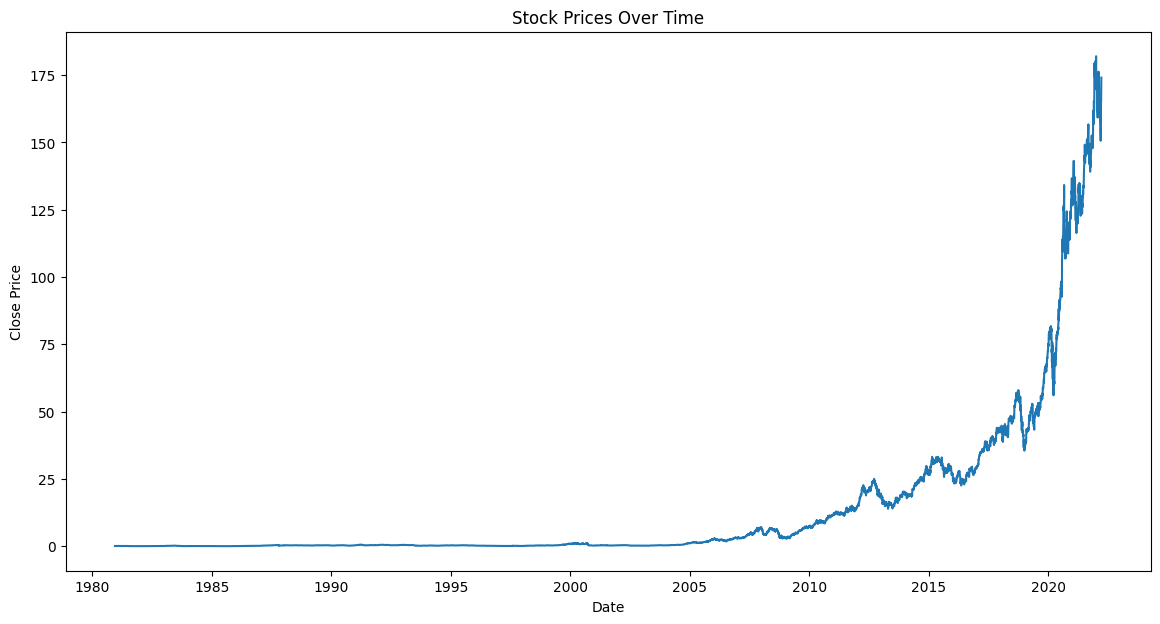

In [9]:
# use pit to visualize stock prices over the time, so we can understand the trends
plt.figure(figsize=(14, 7))
plt.plot(df['Close'])
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

**LSTM**

In [10]:
# we want to make convergence faster
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

**Training** **and** **Testing**

In [11]:
# split the scaled data into training sets, we are going to use 80 to 20%
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# we are using the inputs to predict the output based on the later days
def create_dataset(data, time_step=1):
    X = []
    y = []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshapes the input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


**Build and Train**

In [12]:
model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\epeki\scoop\apps\python\current\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Train Model**

In [13]:
# training the model
hist = model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=2)

Epoch 1/20
259/259 - 45s - 173ms/step - loss: 3.1043e-05
Epoch 2/20
259/259 - 36s - 140ms/step - loss: 1.7617e-05
Epoch 3/20
259/259 - 41s - 160ms/step - loss: 1.0392e-05
Epoch 4/20
259/259 - 47s - 180ms/step - loss: 1.0004e-05
Epoch 5/20
259/259 - 31s - 122ms/step - loss: 1.3163e-05
Epoch 6/20
259/259 - 34s - 130ms/step - loss: 9.0919e-06
Epoch 7/20
259/259 - 45s - 176ms/step - loss: 1.0288e-05
Epoch 8/20
259/259 - 32s - 124ms/step - loss: 1.2179e-05
Epoch 9/20
259/259 - 45s - 172ms/step - loss: 1.0004e-05
Epoch 10/20
259/259 - 34s - 132ms/step - loss: 8.2720e-06
Epoch 11/20
259/259 - 41s - 159ms/step - loss: 8.2952e-06
Epoch 12/20
259/259 - 47s - 181ms/step - loss: 1.0482e-05
Epoch 13/20
259/259 - 44s - 171ms/step - loss: 9.4766e-06
Epoch 14/20
259/259 - 39s - 152ms/step - loss: 8.6445e-06
Epoch 15/20
259/259 - 34s - 131ms/step - loss: 1.1433e-05
Epoch 16/20
259/259 - 39s - 150ms/step - loss: 1.3121e-05
Epoch 17/20
259/259 - 31s - 120ms/step - loss: 7.6030e-06
Epoch 18/20
259/259 - 6

**Plot the Loss**

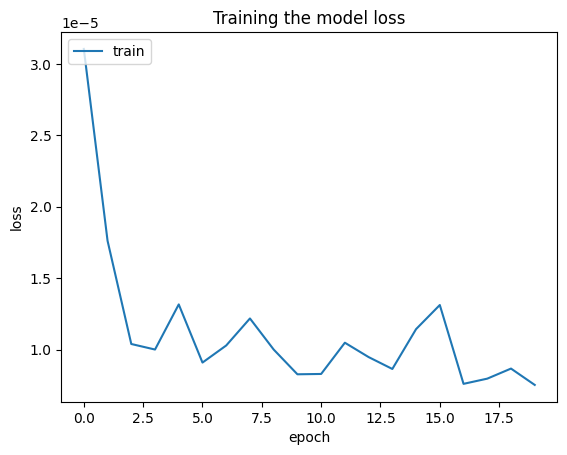

In [14]:
plt.plot(hist.history['loss'])
plt.title('Training the model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train'], loc='upper left')
plt.show()

**Predictions**

In [15]:
#train and test the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# since we scaled earlier we need to inverse and transform to get the actual stock prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


259/259 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step


**Plot Predictions**

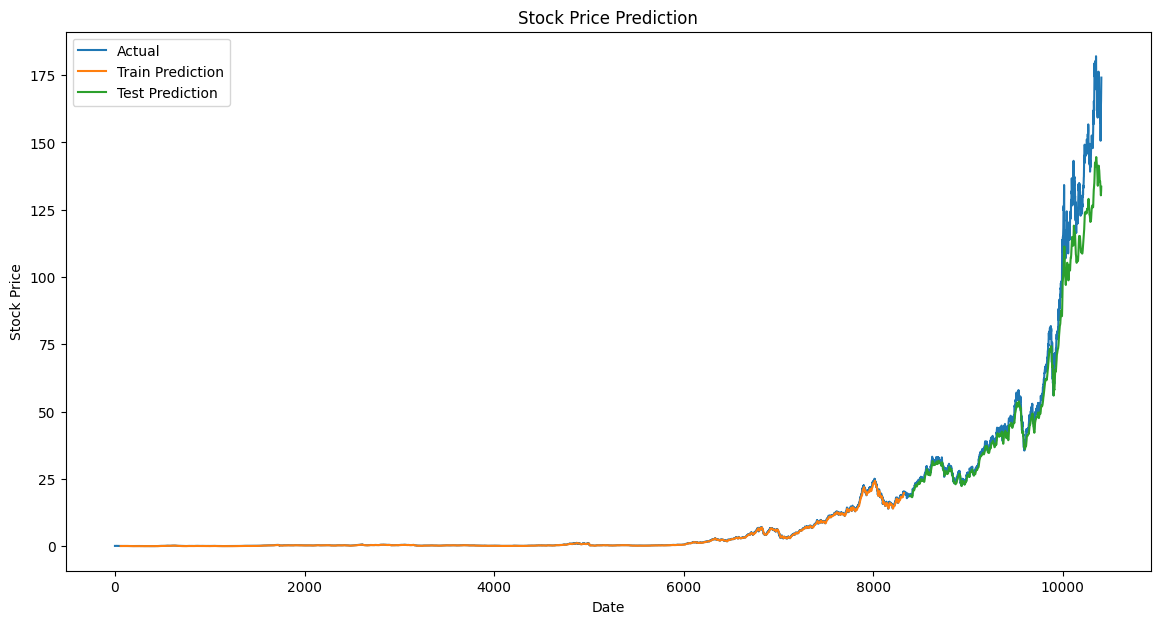

In [16]:
# Shift train predictions for plotting
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(['Actual', 'Train Prediction', 'Test Prediction'])
plt.show()


**Test Model With a Different Dataset**

In [17]:
# load the data to test it
# file = '/content/drive/MyDrive/apple.csv'
file = 'datasets/tesla.csv'
testData = pd.read_csv(file)

# ensuring that the Date column is parsed correctly
testData["Date"] = pd.to_datetime(testData["Date"])
testData.set_index('Date', inplace=True)

# this selects the 'Close' column and drop any None or empty values
testData = testData[['Close']].dropna()

# normalize the dataset using the same scaler we used during training
scaler = MinMaxScaler(feature_range=(0, 1))
input_closingScaled = scaler.fit_transform(testData.values)

# check the shape of the scaled data
input_closingScaled.shape

(1692, 1)

In [18]:
# initialize variables for testing
x_test = []
time_step = 60
length = len(testData)

# create input sequences for the test model
for i in range(time_step, length):
    x_test.append(input_closingScaled[i-time_step:i, 0])

# convert to numpy array and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape


(1632, 60, 1)

In [19]:
# makes the prediction
y_pred = model.predict(x_test)

# we inverse transform the predictions to get actual stock prices
predicted_price = scaler.inverse_transform(y_pred)


51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step


**Visualization**

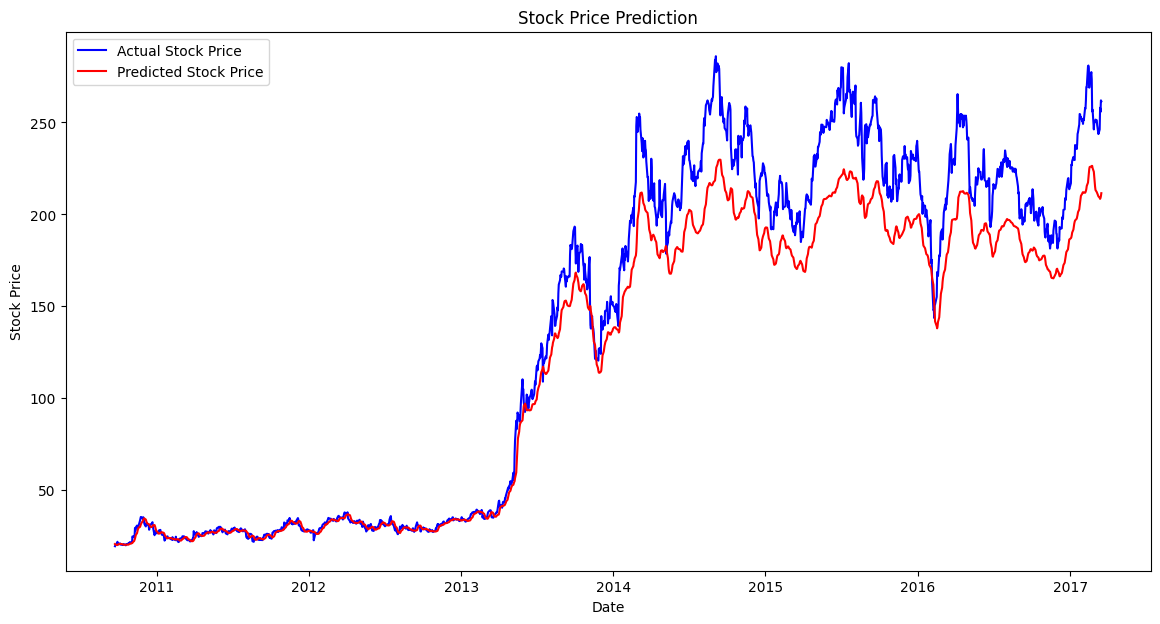

In [20]:
# get the actual closing prices for comparison
y_test = testData.iloc[time_step:, 0].values

# plot the results
plt.figure(figsize=(14, 7))
plt.plot(testData.index[time_step:], y_test, color='blue', label='Actual Stock Price')
plt.plot(testData.index[time_step:], predicted_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


**Performance Metrics**

In [21]:
# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test, predicted_price)
rmse = np.sqrt(mse)

# Print the performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 577.6523110913125
Root Mean Squared Error (RMSE): 24.03439849655723


In [22]:
import joblib

# Save the model
model.save('stock_prediction_model.h5')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']